<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [97]:
import pandas as pd
import pandas_profiling as pf
from scipy import stats
import seaborn as sns

In [29]:
path_raw = '../data/raw/'

df = pd.read_csv(path_raw + 'ecommerce.csv', encoding='latin1', sep=',')
df.shape

(541909, 8)

In [2]:
profile = pf.ProfileReport(df, title='Ecommerce - Profile Report')
profile.to_file('../documentation/Ecommerce - Profile Report.html')

**Tratamento dos dados**

Objetivo
> Tratar tipos das variáveis, normalizá-las e remover valores extremos

Informações em: ".../documentation/Variaveis.xlsx"

In [129]:
#Criar variável InvoiceStatus: Caso InvoiceNo comece com "C", o status será Cancelled, se não Done
df['InvoiceStatus'] = df['InvoiceNo'].apply(lambda x: 'Cancelled' if x.startswith('C') else 'Done')

#Fillnan
df['Description'].fillna('', inplace=True)
df['CustomerID'].fillna('', inplace=True)

#Flag para indicar presença de valores extremos em Quantity
df['QuantityOutlier'] = False

#Pq alguns pedidos com status Done possuem Quantidade menor ou igual a zero?
# Caso 1 - Todos possuem UnitPrice = 0 e Country = United Kingdom e InvoiceStatus = Done e CustomerID vazio
# - Aparentemente foram lançamentos manuais afim de indicar saída de um produto danificado, perdido, etc.
df.loc[(df['InvoiceStatus'] == 'Done') & (df['Quantity'] <= 0), 'QuantityOutlier'] = True

#Quantity: Calculando ZScore para detecção de outliers
df['QuantityZScore'] = stats.zscore(df['Quantity'])
#QuantityOutlierZScore
df['QuantityOutlierZScore'] = False
df.loc[(df['QuantityZScore'] > 3) | (df['QuantityZScore'] < -3), 'QuantityOutlierZScore'] = True

#Cast datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

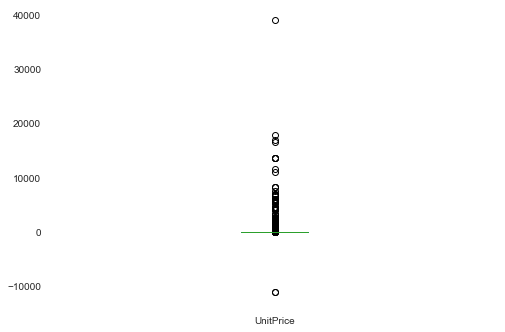

In [143]:
df['UnitPrice'].plot(kind='box')

In [147]:
df.query('InvoiceStatus == "Done"').sort_values(by='UnitPrice', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceStatus,QuantityOutlier,QuantityZScore,QuantityOutlierZScore
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,,United Kingdom,Done,False,-0.039216,False
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,,United Kingdom,Done,False,-0.039216,False
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom,Done,False,-0.039216,False
297723,562955,DOT,DOTCOM POSTAGE,1,2011-08-11 10:14:00,4505.17,,United Kingdom,Done,False,-0.039216,False
268028,560373,M,Manual,1,2011-07-18 12:30:00,4287.63,,United Kingdom,Done,False,-0.039216,False
...,...,...,...,...,...,...,...,...,...,...,...,...
146985,549036,84993B,,-54,2011-04-05 17:09:00,0.00,,United Kingdom,Done,True,-0.291416,False
146984,549035,72051S,,-15,2011-04-05 17:09:00,0.00,,United Kingdom,Done,True,-0.112583,False
313701,564533,23348,,100,2011-08-25 15:09:00,0.00,,United Kingdom,Done,False,0.414744,False
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,,United Kingdom,Done,False,-0.039216,False


In [148]:
#df['CustomerID'].value_counts()

           135080
17841.0      7983
14911.0      5903
14096.0      5128
12748.0      4642
            ...  
13135.0         1
12943.0         1
15313.0         1
17956.0         1
13747.0         1
Name: CustomerID, Length: 4373, dtype: int64